# Time Lapse

Aswin van Woudenberg (https://www.aswinvanwoudenberg.com | https://github.com/afvanwoudenberg)

## Introduction

This notebook creates an 'aging' time lapse video out of a set of selfies. It automatically scales and translates images to align face landmarks.

## Import libraries

We start by importing the necessary libraries. We use MediaPipe to detect face landmarks.

In [1]:
import cv2
import os
import glob
import itertools

import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

# MediaPipe

MediaPipe is a framework developed by Google that bundles several ML solutions to process images and video. The Face Mesh component estimates 468 3D face landmarks. Below we show how this component can be used. 

We first load an image using the OpenCV 2 library and plot it using Matplotlib.

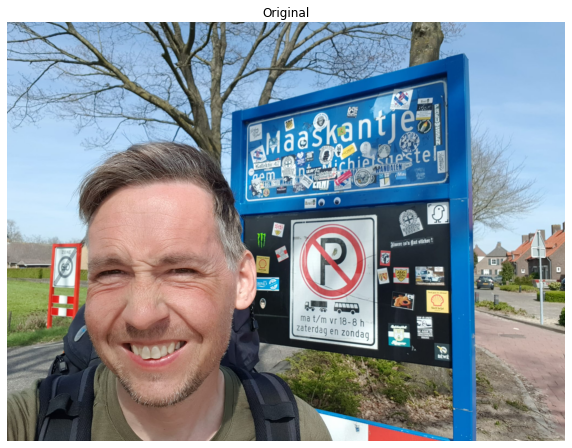

In [2]:
FILENAME = "selfie.jpg"
image = cv2.imread(FILENAME)

plt.figure(figsize = [10, 10])
plt.title("Original")
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Then we find the landmarks and draw a mesh on the image.

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

with mp_face_mesh.FaceMesh(static_image_mode=True, 
            max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
    image = cv2.imread(FILENAME)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # print and draw face mesh landmarks on the image.
    for face_landmarks in results.multi_face_landmarks:
        print("face_landmarks:", face_landmarks)
        mp_drawing.draw_landmarks(image=image, landmark_list=face_landmarks, 
            connections=mp_face_mesh.FACEMESH_TESSELATION, landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(image=image,
            landmark_list=face_landmarks, connections=mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=None, 
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(image=image, landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES, landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())

face_landmarks: landmark {
  x: 0.2552731931209564
  y: 0.7649726271629333
  z: -0.025051934644579887
}
landmark {
  x: 0.2378310114145279
  y: 0.7229021191596985
  z: -0.06819723546504974
}
landmark {
  x: 0.24486427009105682
  y: 0.7329466938972473
  z: -0.034323085099458694
}
landmark {
  x: 0.2283976823091507
  y: 0.6597128510475159
  z: -0.05495115742087364
}
landmark {
  x: 0.23629574477672577
  y: 0.7045442461967468
  z: -0.07378120720386505
}
landmark {
  x: 0.23655498027801514
  y: 0.6788580417633057
  z: -0.07114017009735107
}
landmark {
  x: 0.23971331119537354
  y: 0.6154796481132507
  z: -0.044894181191921234
}
landmark {
  x: 0.1730528324842453
  y: 0.6060908436775208
  z: 0.0222184956073761
}
landmark {
  x: 0.2391943633556366
  y: 0.5754653811454773
  z: -0.0399995818734169
}
landmark {
  x: 0.2377454787492752
  y: 0.5538238286972046
  z: -0.044497113674879074
}
landmark {
  x: 0.23629061877727509
  y: 0.4641753137111664
  z: -0.04180223122239113
}
landmark {
  x: 0.255

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


 We then show the result.

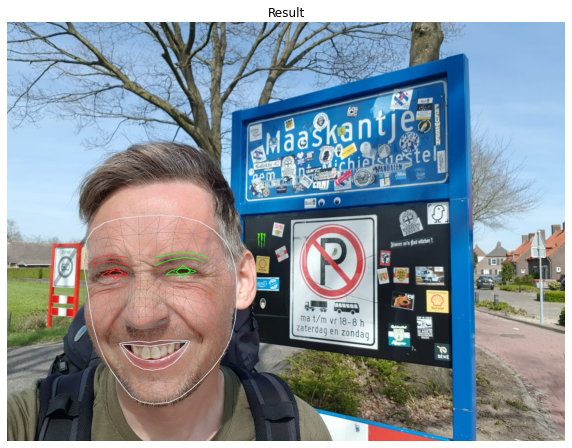

In [4]:
plt.figure(figsize = [10, 10])
plt.title("Result")
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In the remainder of this notebook we're only interested in a few specific landmarks to figure out how to scale and translate images so that they can be stitched together into a time lapse video.

The index numbers for the different landmarks can be found in [this image](https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png?raw=true).


# Constants

We define some constants including the indexes of the landmarks we're interested in. You can experiment with the FPS parameter that tells you how many different images will be shown in one second.

In [5]:
IMG_PATH = "selfies/" # the input directory
OUTPUT_PATH = "output/" # also used for temporary files
VIDEO_NAME = 'video.avi' # the output filename
FPS = 3 # frames per second

NOSE_TIP_LANDMARK = 1
LEFTMOST_LANDMARK = 234
RIGHTMOST_LANDMARK = 454

# Setup

To start we'll delete all files in `OUTPUT_PATH`.

In [6]:
files = glob.glob(os.path.join(OUTPUT_PATH, "*"))
for f in files:
    os.remove(f)

# Helper functions

We'll define a function that converts a landmark back into a pixel coordinate:

In [7]:
def to_pixel_coord(image, landmark):
    # convert landmark to pixel coordinates
    [height, width, _] = image.shape
    return int(landmark.x * width), int(landmark.y * height)

Another function loops through all files in a directory and tries to determine the landmarks' pixel coordinates. The result is returned as a Pandas dataframe.

In [8]:
def read_landmarks(path):
    # find all files in directory
    filenames = [f for f in listdir(path) if isfile(join(path, f))]
    filenames.sort()
    
    # create an empty dataframe
    columns = {
        "file": str(), 
        "nose_tip_x": int(), "nose_tip_y": int(), 
        "leftmost_x": int(), "leftmost_y": int(), 
        "rightmost_x": int(), "rightmost_y": int(),
        "width": int(), "height": int()
    }
    df = pd.DataFrame(columns, index=[])
    
    # find the landmarks' pixel coordinates
    with mp_face_mesh.FaceMesh(static_image_mode=True, 
                max_num_faces=1, refine_landmarks=True, 
                min_detection_confidence=0.5) as face_mesh:
        for file in filenames:
            image = cv2.imread(os.path.join(path, file))
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if not len(results.multi_face_landmarks) == 1:
                # detected less or more than one face -> skip image
                continue
            face_landmarks = results.multi_face_landmarks[0]
            nose_tip_x, nose_tip_y = to_pixel_coord(image, face_landmarks.landmark[NOSE_TIP_LANDMARK])
            leftmost_x, leftmost_y = to_pixel_coord(image, face_landmarks.landmark[LEFTMOST_LANDMARK])
            rightmost_x, rightmost_y = to_pixel_coord(image, face_landmarks.landmark[RIGHTMOST_LANDMARK])
            [height, width, _] = image.shape
            landmarks_xy = [file, nose_tip_x, nose_tip_y, leftmost_x, leftmost_y, rightmost_x, rightmost_y, width, height]
            df = pd.concat([df, pd.DataFrame([landmarks_xy], columns=list(columns.keys()))], ignore_index=True)
    
    return df

We also need a function to scale images.

In [9]:
def scale_image(filename_input, filename_output, factor):
    # read image from disk
    image = cv2.imread(filename_input)
    
    (height, width) = image.shape[:2]

    res = cv2.resize(image, (int(width * factor), int(height * factor)), interpolation = cv2.INTER_CUBIC)
  
    # write image back to disk.
    cv2.imwrite(filename_output, res)

This function translates an image. Translating an image means shifting it within a given frame of reference.

In [10]:
def translate_image(filename_input, filename_output, x, y):
    # if the shift is (x, y) then the translation matrix would be
    # M = [1 0 x]
    #     [0 1 y]
    M = np.float32([[1, 0, x], [0, 1, y]])
    
    # read image from disk.
    image = cv2.imread(filename_input)
    (rows, cols) = image.shape[:2]
  
    # warpAffine does appropriate shifting given the translation matrix.
    res = cv2.warpAffine(image, M, (cols, rows))
  
    # write image back to disk.
    cv2.imwrite(filename_output, res)

# Process images

Find landmarks, scale, and translate images so that they align properly.

## Find landmarks

In [11]:
df = read_landmarks(IMG_PATH)

## Scale images

Rescale the images to make the face in each photo of similar size.

In [12]:
mean_face_size = int(df.rightmost_x.mean()) - int(df.leftmost_x.mean())

In [13]:
for _, row in df.iterrows():
    filename = row['file']
    face_size = row['rightmost_x'] - row['leftmost_x']
    scale_image(os.path.join(IMG_PATH, filename), os.path.join(OUTPUT_PATH, filename), mean_face_size / face_size)

After rescaling, find the landmarks again as they have changed.

In [14]:
df = read_landmarks(OUTPUT_PATH)

## Translate images

Find the average location of the tip of the nose. Then translate all images so that the tips of the noses align. We keep track of how much an image is maximally shifted in the horizontal or vertical direction so we can properly crop the images later.

In [15]:
mean_x = int(df.nose_tip_x.mean())
mean_y = int(df.nose_tip_y.mean())

In [16]:
crop_left = 0
crop_right = 0
crop_top = 0
crop_bottom = 0

In [17]:
for _, row in df.iterrows():
    filename = row['file']
    shift_x = mean_x - row['nose_tip_x']
    shift_y = mean_y - row['nose_tip_y']
    translate_image(os.path.join(OUTPUT_PATH, filename), os.path.join(OUTPUT_PATH, filename), shift_x, shift_y)
    
    if shift_x > 0 and shift_x > crop_left:
        crop_left = shift_x
    elif shift_x < 0 and abs(shift_x) > crop_right:
        crop_right = abs(shift_x)
    elif shift_y > 0 and shift_y > crop_top:
        crop_top = shift_y
    elif shift_y < 0 and abs(shift_y) > crop_bottom:
        crop_bottom = abs(shift_y)

## Crop images

Because of translating we ended up with images with black bars on the sides. We crop images so that these disappear. This way we end up with images that are a bit smaller.

In [18]:
min_width = df.width.min()
min_height = df.height.min()

for _, row in df.iterrows():
    filename = row['file']
    image = cv2.imread(os.path.join(OUTPUT_PATH, filename))
    (rows, cols) = image.shape[:2]
    res = image[crop_top:min_height, crop_left:min_width]
    cv2.imwrite(os.path.join(OUTPUT_PATH, filename), res)

# Create video

Concatenate all images into a video and delete any temporary files.

In [19]:
images = [img for img in os.listdir(OUTPUT_PATH)]
images.sort()
frame = cv2.imread(os.path.join(OUTPUT_PATH, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(os.path.join(OUTPUT_PATH, VIDEO_NAME), 0, FPS, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(OUTPUT_PATH, image)))

cv2.destroyAllWindows()
video.release()

for image in images:
    os.remove(os.path.join(OUTPUT_PATH, image))

All done!